---
## Linear Quadratic Model Predictive Control

*Simulate Model Predictive Control (MPC) by converting the MPC optimization problem to a Linear Quadratic problem. The new problem is optimized using the Operator Splitting Quadratic Program (OSQP).*

**Jake Miller and Kyle Johnsen**  
**SIP Lab**   
**Georgia Institute of Technology**  

---

#### Imports

We make use of [OSQP](https://osqp.org/docs/index.html) in order to calculate optimal trajectories. OSQP does not have to be directly imported, but is used within LQMPC. Scipy is used for efficient sparse matrix operations.

In [1]:
import numpy as np
from scipy import sparse
import lqmpc

#### Dynamics

In our example, we take a linear dynamical system describing the spiking behavior of a population of neurons.

$$ x_{t+1} = Ax_{t} + Bu_{t} $$
$$ y_{t} = Cx_{t} + Du_{t} $$

We take $x\in\mathbb{R}^n$, $u\in\mathbb{R}^m$, and $y\in\mathbb{R}^o$.

In [2]:
A = np.array([[1, -6.66e-13, -2.03e-9, -4.14e-6],                               # System matrix (n x n)
              [9.83e-4, 1, -4.09e-8, -8.32e-5],
              [4.83e-7, 9.83e-4, 1, -5.34e-4],
              [1.58e-10, 4.83e-7, 9.83e-4, .9994]])
B = np.array([[9.83e-4, 4.83e-7, 1.58e-10, 3.89e-14]]).T                        # Control matrix (n x m)
C = np.array([[-.0096, .0135, .005, -.0095]])                                   # Output matrix (o x n)

n, m = B.shape
t_step = 0.001                                                                  # Dynamics for 1 ms

#### Cost Function

We define a cost function which includes the ability to have a state penalty, input penalty, and differential input penalty. The state penalties occur over the prediction horizon while the input penalties over the control horizon. MPC subjects this cost function to particular constraints:

$$ J = \sum_{i=1}^N (x_i-x_r)^TQ(x_i-x_r) + \sum_{i=1}^M u_i^TRu_i + \Delta u_i^T S \Delta u_i $$
$$ x_{i+1} = Ax_{i} + Bu_{i} $$
$$ x_{min} \leq x \leq x_{max} $$
$$ u_{min} \leq u \leq u_{max} $$
$$ x_1 = x_0 $$

where $ N $ is the prediction horizon, $M$ the control horizon, $Q$ the state penalty matrix, $R$ the input penalty matrix, $S$ the differential input penalty matrix, $x_r$ the reference state, and $x_0$ a varying initial state provided on each step. To calculate the first differential input $\Delta u_1=u_1-u_0$, an initial input $u_0$ will be defined only for the calculation of cost.

In [3]:
N = 25                                                                          # Prediction horizon

Q = C.T@C                                                                       # State penalty
R = sparse.eye(m)*1e-6                                                          # Input penalty 

umin = np.array([0])                                                            # Lower input bound                                     
umax = np.array([10])                                                           # Upper input bound

x0 = np.zeros(n)                                                                # Initial state
u0 = np.zeros(m)                                                                # Initial input

#### Reference

When using LQMPC, state references can be supplied per step or for a full simulation loop. For this example, we aim to clamp the output spiking rate, represented with a peri-stimulus time histogram (PSTH), to a sine reference. We use a non-linear function to convert the control ouput to the PSTH.

We will define our reference for the full loop. The reference is defined on the $t_{step}$ scale but sampled from on the $t_{sim}$ scale. We will simulate for $L=120$ simulation steps, so we must define the reference with length $(L+N)(t_{sim}/t_{step})$.

In [4]:
L = 120                                                                         # Number of simulation steps
t_sim = 0.25                                                                    # Simulation time step in seconds
ref_len = (L + N)*int(t_sim/t_step)                                             # Length of reference

def z_to_y(z):
    # From PSTH to output
    return (np.log(z)+5.468)/61.4
def y_to_z(y):
    # From output to PSTH
    return np.exp(61.4*np.array(y)-5.468)

inv = np.linalg.inv
I = np.eye(4)

zr = 0.1 * np.sin(np.linspace(0,2*np.pi,ref_len) * 8) + 0.2                     # Sine reference
yr = z_to_y([zr])
ur = inv(C@inv(I-A)@B)@yr
xr = inv(I-A)@B@ur                                                              # Full reference state

#### Simulate

Now that we have prepared all the necessary inputs, we can simulate the system with control dynamics. There is also an option to print out how long it takes to run a simulation step or full loop.

Simulation Time: 0.51150703 s 
Mean Step Time: 0.00426256 s 



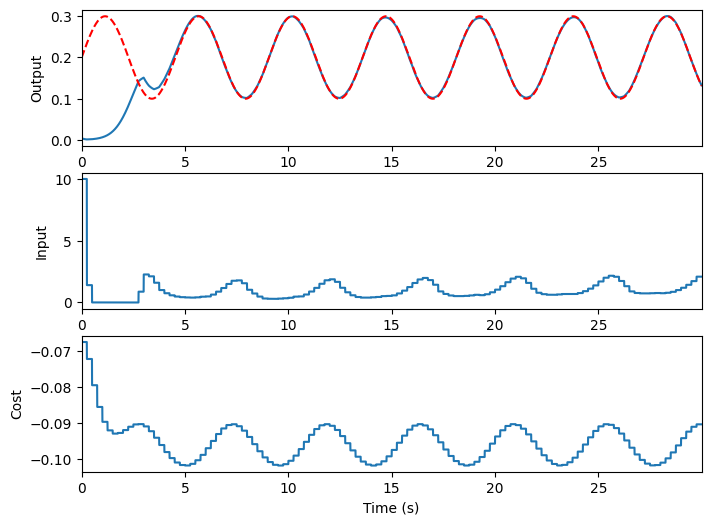

In [5]:
mpc = lqmpc.LQMPC(t_step,A,B,C)                                                 # Instantiate object with dynamics
mpc.set_control(Q=Q,R=R,N=N,M=20)                                               # Set the control parameters
mpc.set_constraints(umin=umin,umax=umax)                                        # Set the constraints
mpc.simulate(t_sim, x0, u0, xr, L)                                              # Perform a full simulation loop
mpc.plot(f=y_to_z)                                                              # Plot the results

---